## DFO Nutrient Comparison

In [1]:
import sqlalchemy
from sqlalchemy import (create_engine, Column, String, Integer, Float, MetaData, 
                        Table, type_coerce, ForeignKey, case)
from sqlalchemy.orm import mapper, create_session, relationship, aliased, Session
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import case
import numpy as np
from sqlalchemy.ext.automap import automap_base
import matplotlib.pyplot as plt
import sqlalchemy.types as types
from sqlalchemy.sql import and_, or_, not_, func
from sqlalchemy.sql import select
import os
from os.path import isfile
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import datetime
import glob
import gsw

%matplotlib inline

In [2]:
PATH= '/data/eolson/MEOPAR/SS36runs/CedarRuns/spring2015_NoMZME/'
start_date = datetime.datetime(2015,2,6)
end_date = datetime.datetime(2015,10,3)
#end_date = datetime.datetime(2015,11,12)
flen=10
namfmt='long'
#varmap={'N':'nitrate','Si':'silicon','Ammonium':'ammonium'}
filemap={'nitrate':'ptrc_T','silicon':'ptrc_T','ammonium':'ptrc_T','diatoms':'ptrc_T','ciliates':'ptrc_T','flagellates':'ptrc_T'}
#gridmap={'nitrate':'tmask','silicon':'tmask','ammonium':'tmask'}
fdict={'ptrc_T':1,'grid_T':1}

df1=et.loadDFO()
df1.head()

,Year,Month,Day,Hour,Lat,Lon,Pressure,Depth,Ammonium,Ammonium_units,Chlorophyll_Extracted,Chlorophyll_Extracted_units,N,Si,Silicate_units,AbsSal,T,T_units,Z,dtUTC
0,2015.0,2.0,11.0,11.068611,48.300833,-124.000333,1.9,None,None,None,NaN,mg/m^3,15.31,32.14,umol/L,29.227507,9.7647,'deg_C_(ITS90)',1.884,2015-02-11 11:04:07
1,2015.0,2.0,11.0,11.068611,48.300833,-124.000333,6.6,None,None,None,2.57,mg/m^3,17.13,33.90,umol/L,29.484341,9.6880,'deg_C_(ITS90)',6.54434,2015-02-11 11:04:07
2,2015.0,2.0,11.0,11.068611,48.300833,-124.000333,6.7,None,None,None,NaN,mg/m^3,NaN,NaN,umol/L,29.484839,9.6828,'deg_C_(ITS90)',6.6435,2015-02-11 11:04:07
3,2015.0,2.0,11.0,11.068611,48.300833,-124.000333,11.0,None,None,None,NaN,mg/m^3,NaN,NaN,umol/L,30.144549,9.3646,'deg_C_(ITS90)',10.9071,2015-02-11 11:04:07
4,2015.0,2.0,11.0,11.068611,48.300833,-124.000333,11.0,None,None,None,NaN,mg/m^3,20.62,37.65,umol/L,30.157913,9.3586,'deg_C_(ITS90)',10.9071,2015-02-11 11:04:07


In [3]:
data=et.matchData(df1,filemap, fdict, start_date, end_date, namfmt, PATH, flen)

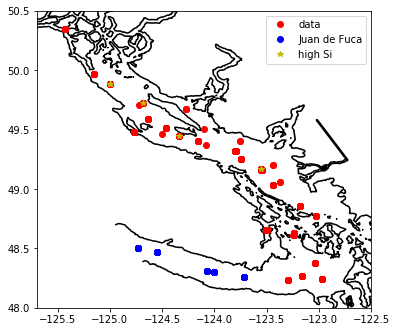

In [4]:
fig, ax = plt.subplots(figsize = (6,6))
viz_tools.set_aspect(ax, coords = 'map')
ax.plot(data['Lon'], data['Lat'], 'ro',label='data')
ax.plot(data.loc[(data.Lon < -123.5) & (data.Lat < 48.6),['Lon']], 
        data.loc[(data.Lon < -123.5) & (data.Lat < 48.6),['Lat']], 
        'bo', label = 'Juan de Fuca')

ax.plot(data.loc[data.Si>75,['Lon']],data.loc[data.Si>75,['Lat']],'*',color='y',label='high Si')
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
viz_tools.plot_coastline(ax, grid, coords = 'map')
ax.set_ylim(48, 50.5)
ax.legend()
ax.set_xlim(-125.7, -122.5);

# Nitrate

In [5]:
N_s, modmean_s, obsmean_s, bias_s, RMSE_s, WSS_s = et.stats(data.loc[data.Z<15,['N']],data.loc[data.Z<15,['mod_nitrate']])
N_i, modmean_i, obsmean_i, bias_i, RMSE_i, WSS_i = et.stats(data.loc[(data.Z>=15)&(data.Z<22),['N']],data.loc[(data.Z>=15)&(data.Z<22),['mod_nitrate']])
N_d, modmean_d, obsmean_d, bias_d, RMSE_d, WSS_d = et.stats(data.loc[data.Z>=22,['N']],data.loc[data.Z>=22,['mod_nitrate']])
N, modmean, obsmean, bias, RMSE, WSS = et.stats(data.loc[:,['N']],data.loc[:,['mod_nitrate']])
print('Nitrate')
print('z<15 m:')
print('  N: {}\n  bias: {}\n  RMSE: {}\n  WSS: {}'.format(N_s,bias_s,RMSE_s,WSS_s))
print('15 m<=z<22 m:')
print('  N: {}\n  bias: {}\n  RMSE: {}\n  WSS: {}'.format(N_i,bias_i,RMSE_i,WSS_i))
print('z>=22 m:')
print('  N: {}\n  bias: {}\n  RMSE: {}\n  WSS: {}'.format(N_d,bias_d,RMSE_d,WSS_d))
print('all:')
print('  N: {}\n  bias: {}\n  RMSE: {}\n  WSS: {}'.format(N,bias,RMSE,WSS))


Nitrate
z<15 m:
  N: 136
  bias: -2.2004546288882985
  RMSE: 5.574862333995962
  WSS: 0.8613777859079017
15 m<=z<22 m:
  N: 41
  bias: -1.9271846026909039
  RMSE: 4.852372751853912
  WSS: 0.6989059275283884
z>=22 m:
  N: 383
  bias: -1.7770715158726418
  RMSE: 3.6611458046393928
  WSS: 0.7523525437201022
all:
  N: 560
  bias: -1.8908837694440557
  RMSE: 4.294067804826921
  WSS: 0.9184889801585957


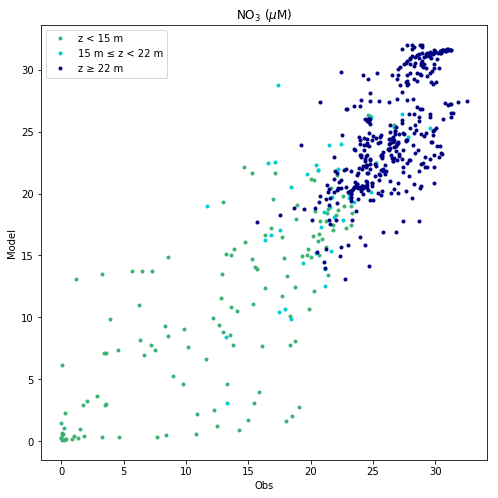

In [6]:
fig, ax = plt.subplots(figsize = (8,8))
ps=et.varvarPlot(ax,data,'N','mod_nitrate','Z',(15,22),'z','m',('mediumseagreen','darkturquoise','navy'))
ax.legend(handles=ps)
ax.set_xlabel('Obs')
ax.set_ylabel('Model')
ax.set_title('NO$_3$ ($\mu$M)')

Nitrate, z<15
Feb-Mar:
  N: 8
  bias: 1.435205383300783
  RMSE: 3.01142358654671
  WSS: 0.7702694726778002
April:
  N: 70
  bias: -3.1590709119524334
  RMSE: 6.773738986865845
  WSS: 0.6850920691983444
May-Jun:
  N: 32
  bias: -1.8340747261047365
  RMSE: 4.356419617234505
  WSS: 0.7991463238512354
Sep-Oct:
  N: 26
  bias: -1.1891562388493444
  RMSE: 3.589785397214403
  WSS: 0.8893109245614527


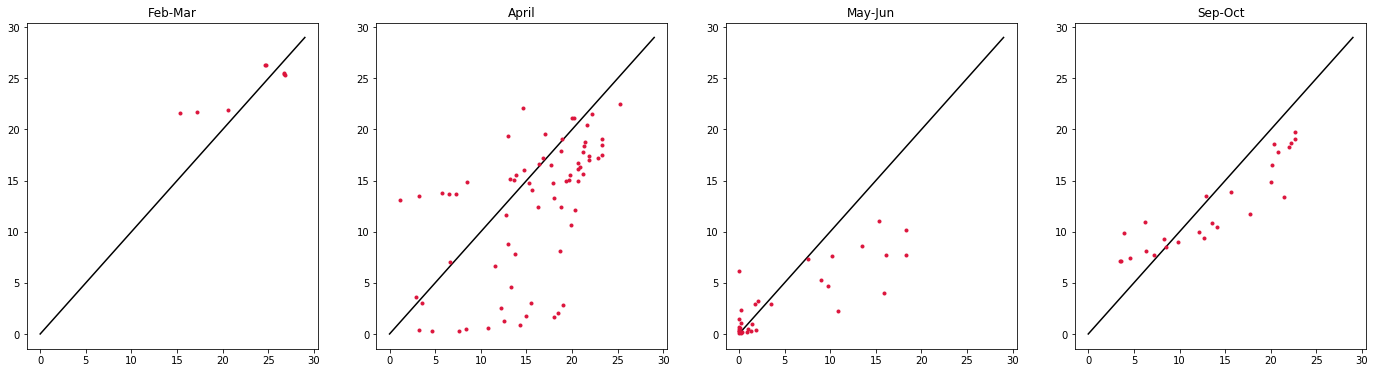

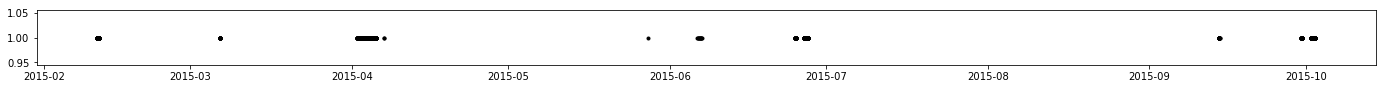

In [7]:
fig, ax = plt.subplots(1,4,figsize = (24,6))
for axi in ax:
    axi.plot(np.arange(0,30),np.arange(0,30),'k-')
ps=et.varvarPlot(ax[0],data.loc[(data.Z<15)&(data.dtUTC<=dt.datetime(2015,4,1)),:],'N','mod_nitrate',cols=('crimson','darkturquoise','navy'))
ax[0].set_title('Feb-Mar')
ii1=(data.Z < 15)&(data.dtUTC<=dt.datetime(2015,5,1))&(data.dtUTC>dt.datetime(2015,4,1))
ps=et.varvarPlot(ax[1],data.loc[ii1,:],'N','mod_nitrate',cols=('crimson','darkturquoise','navy'))
ax[1].set_title('April')
ii2=(data.Z < 15)&(data.dtUTC<=dt.datetime(2015,9,1))&(data.dtUTC>dt.datetime(2015,5,1))
ps=et.varvarPlot(ax[2],data.loc[ii2,:],'N','mod_nitrate',cols=('crimson','darkturquoise','navy'))
ax[2].set_title('May-Jun')
ii3=(data.Z < 15)&(data.dtUTC<=dt.datetime(2015,12,1))&(data.dtUTC>dt.datetime(2015,9,1))
ps=et.varvarPlot(ax[3],data.loc[ii3,:],'N','mod_nitrate',cols=('crimson','darkturquoise','navy'))
ax[3].set_title('Sep-Oct')

print('Nitrate, z<15')
print('Feb-Mar:')
et.printstats(data.loc[(data.Z<15)&(data.dtUTC<=dt.datetime(2015,4,1)),:],'N','mod_nitrate')
print('April:')
et.printstats(data.loc[ii1,:],'N','mod_nitrate')
print('May-Jun:')
et.printstats(data.loc[ii2,:],'N','mod_nitrate')
print('Sep-Oct:')
et.printstats(data.loc[ii3,:],'N','mod_nitrate')
fig,ax=plt.subplots(1,1,figsize=(24,1))
plt.plot(data.dtUTC,np.ones(np.shape(data.dtUTC)),'k.')

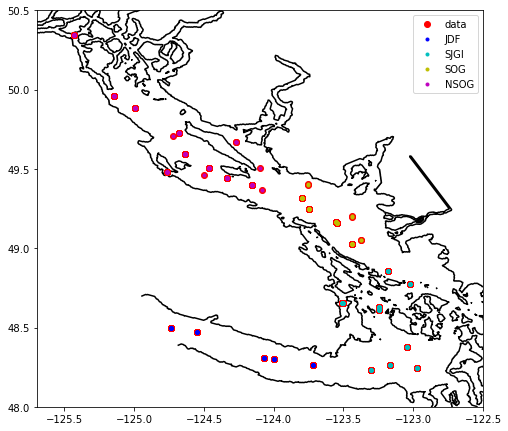

In [8]:
fig, ax = plt.subplots(figsize = (8,8))
viz_tools.set_aspect(ax, coords = 'map')
ax.plot(data['Lon'], data['Lat'], 'ro',label='data')
dJDF=data.loc[(data.Lon<-123.6)&(data.Lat<48.6)]
ax.plot(dJDF['Lon'],dJDF['Lat'],'b.',label='JDF')
dSJGI=data.loc[(data.Lon>=-123.6)&(data.Lat<48.9)]
ax.plot(dSJGI['Lon'],dSJGI['Lat'],'c.',label='SJGI')
dSOG=data.loc[(data.Lat>=48.9)&(data.Lon>-124.0)]
ax.plot(dSOG['Lon'],dSOG['Lat'],'y.',label='SOG')
dNSOG=data.loc[(data.Lat>=48.9)&(data.Lon<=-124.0)]
ax.plot(dNSOG['Lon'],dNSOG['Lat'],'m.',label='NSOG')
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
viz_tools.plot_coastline(ax, grid, coords = 'map')
ax.set_ylim(48, 50.5)
ax.legend()
ax.set_xlim(-125.7, -122.5);

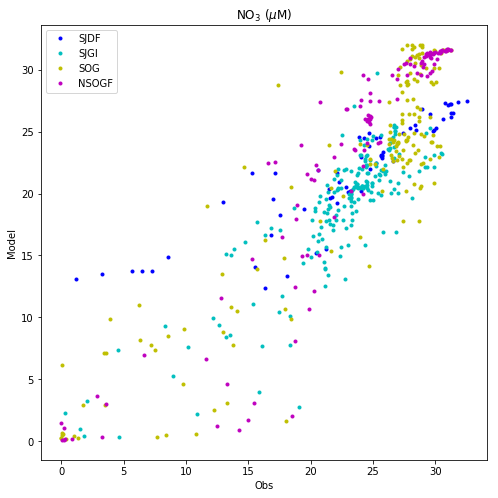

In [9]:
fig, ax = plt.subplots(figsize = (8,8))
ps1=et.varvarPlot(ax,dJDF,'N','mod_nitrate',cols=('b','darkturquoise','navy'),lname='SJDF')
ps2=et.varvarPlot(ax,dSJGI,'N','mod_nitrate',cols=('c','darkturquoise','navy'),lname='SJGI')
ps3=et.varvarPlot(ax,dSOG,'N','mod_nitrate',cols=('y','darkturquoise','navy'),lname='SOG')
ps4=et.varvarPlot(ax,dNSOG,'N','mod_nitrate',cols=('m','darkturquoise','navy'),lname='NSOGF')
ax.legend(handles=[ps1[0][0],ps2[0][0],ps3[0][0],ps4[0][0]])
ax.set_xlabel('Obs')
ax.set_ylabel('Model')
ax.set_title('NO$_3$ ($\mu$M)')

(-40, 20)

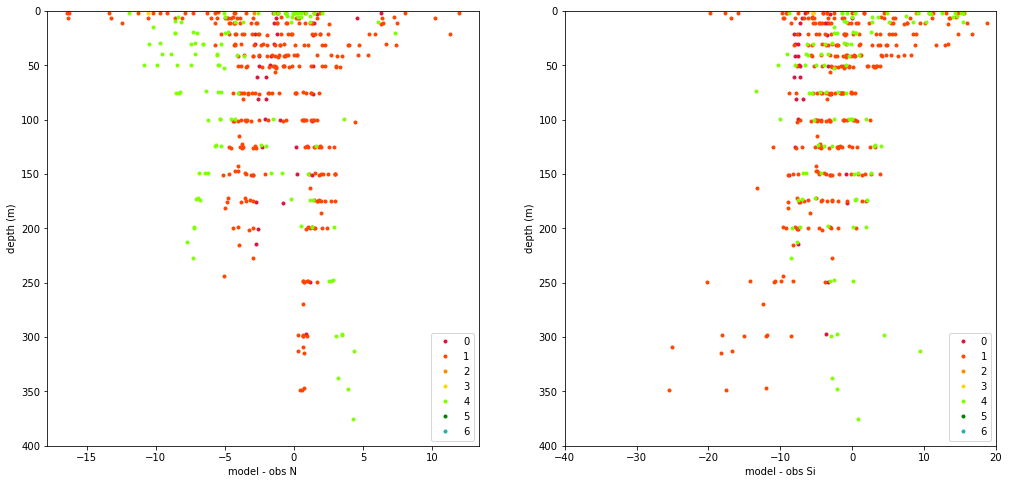

In [10]:
fig, ax = plt.subplots(1,2,figsize = (17,8))
cols=('crimson','orangered','darkorange','gold','chartreuse','green','lightseagreen','cyan',
      'lightskyblue','blue','mediumslateblue','blueviolet','darkmagenta','fuchsia')
ii0=start_date
for ii in range(0,int((end_date-start_date).days/30)):
    iii=(data.dtUTC>=(start_date+dt.timedelta(days=ii*30)))&(data.dtUTC<(start_date+dt.timedelta(days=(ii+1)*30)))
    ax[0].plot(data.loc[iii,['mod_nitrate']].values-data.loc[iii,['N']].values, data.loc[iii,['Z']].values, 
        '.', color = cols[ii],label=str(ii))
    ax[1].plot(data.loc[iii,['mod_silicon']].values-data.loc[iii,['Si']].values, data.loc[iii,['Z']].values, 
        '.', color = cols[ii],label=str(ii))
for axi in (ax[0],ax[1]):
    axi.legend(loc=4)
    axi.set_ylim(400,0)
    axi.set_ylabel('depth (m)')
ax[0].set_xlabel('model - obs N')
ax[1].set_xlabel('model - obs Si')
ax[1].set_xlim(-40,20)

# Silicate

In [11]:
print('Nitrate')
print('z<15 m:')
et.printstats(data.loc[data.Z<15,:],'Si','mod_silicon')
print('15 m<=z<22 m:')
et.printstats(data.loc[(data.Z>=15)&(data.Z<22),:],'Si','mod_silicon')
print('z>=22 m:')
et.printstats(data.loc[data.Z>=22,:],'Si','mod_silicon')
print('all:')
et.printstats(data,'Si','mod_silicon')


Nitrate
z<15 m:
  N: 136
  bias: 3.1400894524069436
  RMSE: 9.117043632001728
  WSS: 0.7711320811808722
15 m<=z<22 m:
  N: 41
  bias: 2.1030872661311477
  RMSE: 7.22749068578051
  WSS: 0.7431729194468029
z>=22 m:
  N: 383
  bias: -2.731972907243133
  RMSE: 5.891621185157409
  WSS: 0.8770706391828201
all:
  N: 560
  bias: -0.9519039916992256
  RMSE: 6.910199121409662
  WSS: 0.8916302440137249


(0, 85)

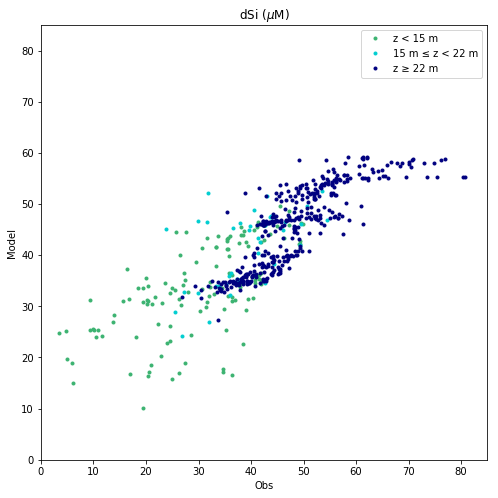

In [12]:
fig, ax = plt.subplots(figsize = (8,8))
ps=et.varvarPlot(ax,data,'Si','mod_silicon','Z',(15,22),'z','m',('mediumseagreen','darkturquoise','navy'))
ax.legend(handles=ps)
ax.set_xlabel('Obs')
ax.set_ylabel('Model')
ax.set_title('dSi ($\mu$M)')
ax.set_xlim(0,85)
ax.set_ylim(0,85)

Silicate, z<15
Feb-Mar:
  N: 8
  bias: -3.699679870605472
  RMSE: 4.8023019447462
  WSS: 0.8687234613341265
April:
  N: 70
  bias: 0.975446829659596
  RMSE: 9.469837611872318
  WSS: 0.7343743807331989
May-Jun:
  N: 32
  bias: 7.063675994873044
  RMSE: 10.401390756589482
  WSS: 0.6039147503793147
Sep-Oct:
  N: 26
  bias: 6.243495882474463
  RMSE: 7.286435276618624
  WSS: 0.5752536043242795


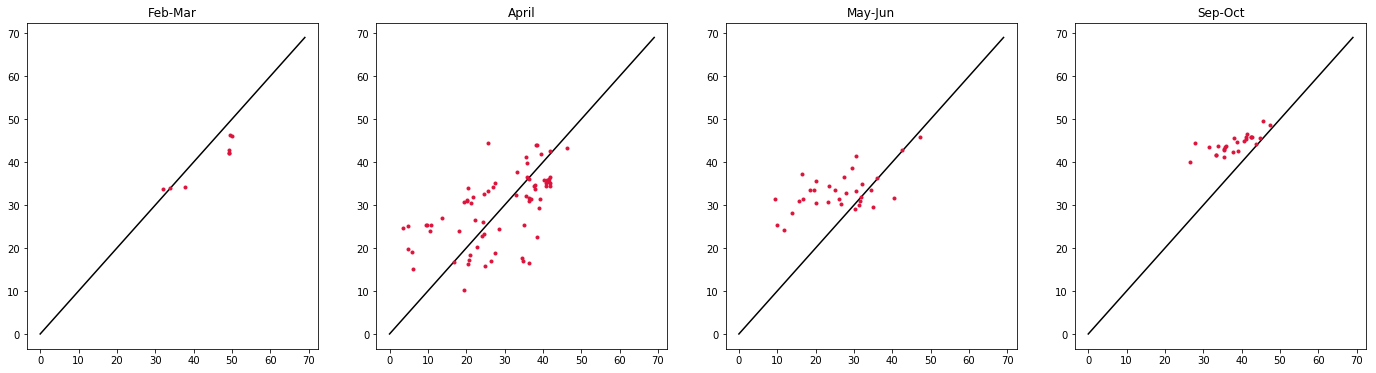

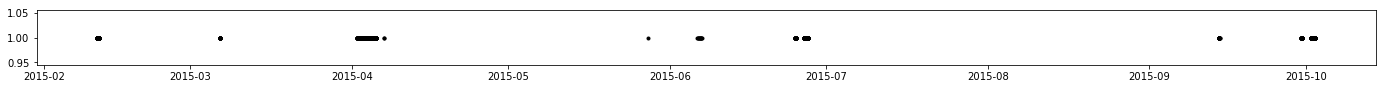

In [13]:
obsvar='Si'; modvar='mod_silicon'
fig, ax = plt.subplots(1,4,figsize = (24,6))
for axi in ax:
    axi.plot(np.arange(0,70),np.arange(0,70),'k-')
ps=et.varvarPlot(ax[0],data.loc[(data.Z<15)&(data.dtUTC<=dt.datetime(2015,4,1)),:],obsvar,modvar,cols=('crimson','darkturquoise','navy'))
ax[0].set_title('Feb-Mar')
ii1=(data.Z < 15)&(data.dtUTC<=dt.datetime(2015,5,1))&(data.dtUTC>dt.datetime(2015,4,1))
ps=et.varvarPlot(ax[1],data.loc[ii1,:],obsvar,modvar,cols=('crimson','darkturquoise','navy'))
ax[1].set_title('April')
ii2=(data.Z < 15)&(data.dtUTC<=dt.datetime(2015,9,1))&(data.dtUTC>dt.datetime(2015,5,1))
ps=et.varvarPlot(ax[2],data.loc[ii2,:],obsvar,modvar,cols=('crimson','darkturquoise','navy'))
ax[2].set_title('May-Jun')
ii3=(data.Z < 15)&(data.dtUTC<=dt.datetime(2015,12,1))&(data.dtUTC>dt.datetime(2015,9,1))
ps=et.varvarPlot(ax[3],data.loc[ii3,:],obsvar,modvar,cols=('crimson','darkturquoise','navy'))
ax[3].set_title('Sep-Oct')

print('Silicate, z<15')
print('Feb-Mar:')
et.printstats(data.loc[(data.Z<15)&(data.dtUTC<=dt.datetime(2015,4,1)),:],obsvar,modvar)
print('April:')
et.printstats(data.loc[ii1,:],obsvar,modvar)
print('May-Jun:')
et.printstats(data.loc[ii2,:],obsvar,modvar)
print('Sep-Oct:')
et.printstats(data.loc[ii3,:],obsvar,modvar)
fig,ax=plt.subplots(1,1,figsize=(24,1))
plt.plot(data.dtUTC,np.ones(np.shape(data.dtUTC)),'k.')

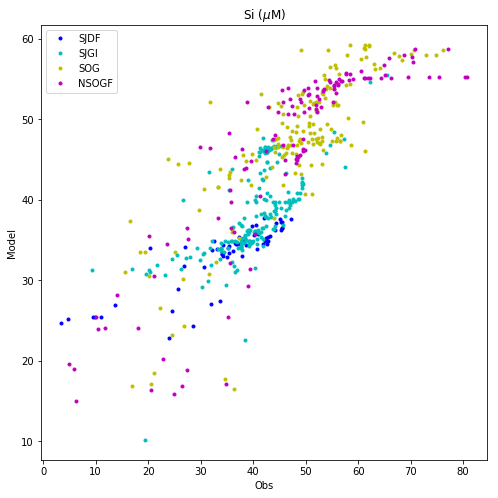

In [14]:
fig, ax = plt.subplots(figsize = (8,8))
ps1=et.varvarPlot(ax,dJDF,obsvar,modvar,cols=('b','darkturquoise','navy'),lname='SJDF')
ps2=et.varvarPlot(ax,dSJGI,obsvar,modvar,cols=('c','darkturquoise','navy'),lname='SJGI')
ps3=et.varvarPlot(ax,dSOG,obsvar,modvar,cols=('y','darkturquoise','navy'),lname='SOG')
ps4=et.varvarPlot(ax,dNSOG,obsvar,modvar,cols=('m','darkturquoise','navy'),lname='NSOGF')
ax.legend(handles=[ps1[0][0],ps2[0][0],ps3[0][0],ps4[0][0]])
ax.set_xlabel('Obs')
ax.set_ylabel('Model')
ax.set_title('Si ($\mu$M)')

# Ratios

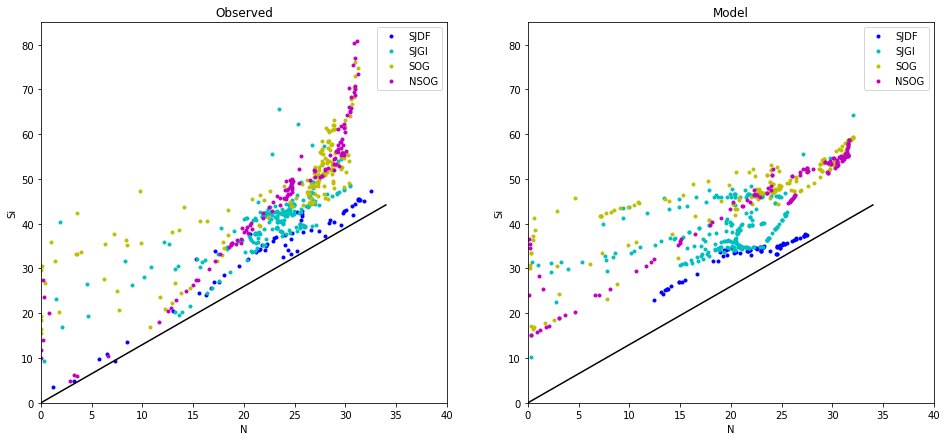

In [15]:
fig,ax=plt.subplots(1,2,figsize=(16,7))
p1=ax[0].plot(dJDF['N'],dJDF['Si'],'b.',label='SJDF')
p2=ax[0].plot(dSJGI['N'],dSJGI['Si'],'c.',label='SJGI')
p3=ax[0].plot(dSOG['N'],dSOG['Si'],'y.',label='SOG')
p4=ax[0].plot(dNSOG['N'],dNSOG['Si'],'m.',label='NSOG')
ax[0].set_title('Observed')
ax[0].set_xlabel('N')
ax[0].set_ylabel('Si')
ax[0].set_xlim(0,40)
ax[0].set_ylim(0,85)
ax[0].legend()

p5=ax[1].plot(dJDF['mod_nitrate'],dJDF['mod_silicon'],'b.',label='SJDF')
p6=ax[1].plot(dSJGI['mod_nitrate'],dSJGI['mod_silicon'],'c.',label='SJGI')
p7=ax[1].plot(dSOG['mod_nitrate'],dSOG['mod_silicon'],'y.',label='SOG')
p8=ax[1].plot(dNSOG['mod_nitrate'],dNSOG['mod_silicon'],'m.',label='NSOG')
ax[1].set_title('Model')
ax[1].set_xlabel('N')
ax[1].set_ylabel('Si')
ax[1].set_xlim(0,40)
ax[1].set_ylim(0,85)
ax[1].legend()
ax[0].plot(np.arange(0,35),1.3*np.arange(0,35),'k-')
ax[1].plot(np.arange(0,35),1.3*np.arange(0,35),'k-')

# Chlorophyll

In [16]:
data['l10_obsChl']=np.log10(data['Chlorophyll_Extracted']+0.01)
data['l10_modChl']=np.log10(2*(data['mod_diatoms']+data['mod_ciliates']+data['mod_flagellates'])+0.01)
data['mod_Chl']=2*(data['mod_diatoms']+data['mod_ciliates']+data['mod_flagellates'])

In [17]:
print('log10[Chl+0.01]')
print('z<15 m:')
et.printstats(data.loc[data.Z<15,:],'l10_obsChl','l10_modChl')
print('z>=15 m:')
et.printstats(data.loc[data.Z>=15,:],'l10_obsChl','l10_modChl')
print('all:')
et.printstats(data,'l10_obsChl','l10_modChl')
print('\n')
print('Chl')
print('z<15 m:')
et.printstats(data.loc[data.Z<15,:],'Chlorophyll_Extracted','mod_Chl')
print('z>=15 m:')
et.printstats(data.loc[data.Z>=15,:],'Chlorophyll_Extracted','mod_Chl')
print('all:')
et.printstats(data,'Chlorophyll_Extracted','mod_Chl')


log10[Chl+0.01]
z<15 m:
  N: 96
  bias: 0.17182464757692512
  RMSE: 0.41964651979491635
  WSS: 0.5984324232550063
z>=15 m:
  N: 38
  bias: 0.29874846087485335
  RMSE: 0.4253531060020494
  WSS: 0.5568900519824231
all:
  N: 134
  bias: 0.20781799223048286
  RMSE: 0.4212726579507837
  WSS: 0.6592088231817896


Chl
z<15 m:
  N: 96
  bias: 0.5639875920613604
  RMSE: 4.077239328912461
  WSS: 0.6945830434776676
z>=15 m:
  N: 38
  bias: 0.7444234694932637
  RMSE: 1.4207931172168697
  WSS: 0.5172304372499779
all:
  N: 134
  bias: 0.6151561976190822
  RMSE: 3.5330015033682427
  WSS: 0.7181654760143069


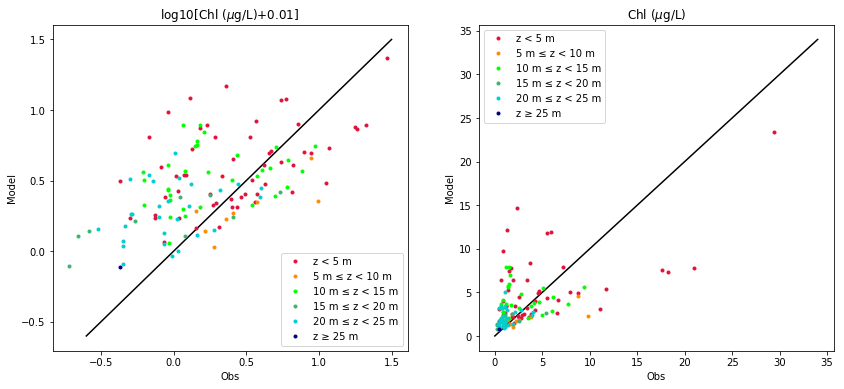

In [18]:
fig, ax = plt.subplots(1,2,figsize = (14,6))
ax[0].plot(np.arange(-.6,1.6,.1),np.arange(-.6,1.6,.1),'k-')
ps=et.varvarPlot(ax[0],data,'l10_obsChl','l10_modChl','Z',(5,10,15,20,25),'z','m',('crimson','darkorange','lime','mediumseagreen','darkturquoise','navy'))
ax[0].legend(handles=ps)
ax[0].set_xlabel('Obs')
ax[0].set_ylabel('Model')
ax[0].set_title('log10[Chl ($\mu$g/L)+0.01]')
ax[1].plot(np.arange(0,35),np.arange(0,35),'k-')
ps=et.varvarPlot(ax[1],data,'Chlorophyll_Extracted','mod_Chl','Z',(5,10,15,20,25),'z','m',('crimson','darkorange','lime','mediumseagreen','darkturquoise','navy'))
ax[1].legend(handles=ps)
ax[1].set_xlabel('Obs')
ax[1].set_ylabel('Model')
ax[1].set_title('Chl ($\mu$g/L)')